In [2]:
#Libraries Preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [3]:
data=pd.read_excel("D:\DATAS\ALDEN\DATA ALDEN.xlsx")

In [4]:
df=data.drop(columns='Kab')
df.head(2)

,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17
0,1,1,60,1,2,1,7,7,1,5,5,1,5,5,2,83,13,0
1,1,1,54,1,2,1,7,7,1,5,5,5,5,5,4,80,3,0


In [5]:
x=df.drop(columns='Y')
y=df['Y']

In [6]:
x_insample, x_outsample, y_insample, y_outsample = train_test_split(x,y, test_size=0.1, random_state=42,shuffle=True)

In [7]:
#Library Base Model
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, log_loss
)

In [8]:
models = {
    "LR": LogisticRegression(max_iter=1000, random_state=42),
    "LR Scaled": Pipeline([("scaler", StandardScaler()), 
                           ("lr", LogisticRegression(max_iter=1000, random_state=42))]),
    "LDA": LinearDiscriminantAnalysis(),
    "DT": DecisionTreeClassifier(random_state=42)
}

In [9]:
param_distributions = {
    "LR": {
        "C": [0.01, 0.1, 1, 10, 100],
        "solver": ["lbfgs", "liblinear", "saga"]
    },
    "LR Scaled": {
        "lr__C": [0.01, 0.1, 1, 10, 100],
        "lr__solver": ["lbfgs", "liblinear", "saga"]
    },
    "LDA": {
        "solver": ["svd", "lsqr", "eigen"],
        "shrinkage": [None, "auto", 0.1, 0.5, 0.9]
    },
    "DT": {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"]
    }
}


In [10]:
metrics = {
    "Accuracy": lambda y_true, y_pred, y_proba: accuracy_score(y_true, y_pred),
    "Precision": lambda y_true, y_pred, y_proba: precision_score(y_true, y_pred),
    "Recall": lambda y_true, y_pred, y_proba: recall_score(y_true, y_pred),
    "F1": lambda y_true, y_pred, y_proba: f1_score(y_true, y_pred),
    "ROC-AUC": lambda y_true, y_pred, y_proba: roc_auc_score(y_true, y_proba),
    "LogLoss": lambda y_true, y_pred, y_proba: log_loss(y_true, y_proba),
}

In [11]:
best_models = {}
results = {}

In [12]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [13]:
for name, model in models.items():
    print(f"\nTuning {name}...")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[name],
        n_iter=30,
        cv=kfold,
        scoring='roc_auc',   # tetap gunakan roc_auc sebagai objective utama
        random_state=42,
        n_jobs=-1
    )
    search.fit(x_insample, y_insample)
    
    best_models[name] = search.best_estimator_
    
    y_pred = search.predict(x_insample)
    y_proba = search.predict_proba(x_insample)[:,1]

    # simpan hasil semua metric
    result_entry = {"Best Params": search.best_params_}
    for metric_name, func in metrics.items():
        result_entry[f"Train {metric_name}"] = func(y_insample, y_pred, y_proba)

    # pakai mean cross-val score (scoring utama: roc_auc)
    result_entry["CV ROC-AUC (mean)"] = search.best_score_
    
    results[name] = result_entry

# jadi DataFrame
results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})
print(results_df.head())


Tuning LR...


c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 15 is smaller than n_iter=30. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Tuning LR Scaled...


c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 15 is smaller than n_iter=30. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Tuning LDA...


c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 15 is smaller than n_iter=30. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
40 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\emanu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_t


Tuning DT...
       Model                                        Best Params  \
0         LR                      {'solver': 'lbfgs', 'C': 0.1}   
1  LR Scaled          {'lr__solver': 'liblinear', 'lr__C': 0.1}   
2        LDA               {'solver': 'svd', 'shrinkage': None}   
3         DT  {'min_samples_split': 10, 'min_samples_leaf': ...   

  Train Accuracy Train Precision Train Recall  Train F1 Train ROC-AUC  \
0       0.870115         0.88745     0.971011  0.927352      0.858492   
1       0.870488        0.887341     0.971665  0.927591      0.858632   
2       0.865836        0.889897     0.961857  0.924479      0.856747   
3       0.865836        0.874347     0.984307  0.926074      0.863743   

  Train LogLoss CV ROC-AUC (mean)  
0       0.29951          0.854946  
1      0.299963          0.855077  
2      0.305527          0.853952  
3      0.292294          0.839794  


In [14]:
results_df

,Model,Best Params,Train Accuracy,Train Precision,Train Recall,Train F1,Train ROC-AUC,Train LogLoss,CV ROC-AUC (mean)
0,LR,"{'solver': 'lbfgs', 'C': 0.1}",0.870115,0.88745,0.971011,0.927352,0.858492,0.29951,0.854946
1,LR Scaled,"{'lr__solver': 'liblinear', 'lr__C': 0.1}",0.870488,0.887341,0.971665,0.927591,0.858632,0.299963,0.855077
2,LDA,"{'solver': 'svd', 'shrinkage': None}",0.865836,0.889897,0.961857,0.924479,0.856747,0.305527,0.853952
3,DT,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.865836,0.874347,0.984307,0.926074,0.863743,0.292294,0.839794


In [15]:
results_df

,Model,Best Params,Train Accuracy,Train Precision,Train Recall,Train F1,Train ROC-AUC,Train LogLoss,CV ROC-AUC (mean)
0,LR,"{'solver': 'lbfgs', 'C': 0.1}",0.870115,0.88745,0.971011,0.927352,0.858492,0.29951,0.854946
1,LR Scaled,"{'lr__solver': 'liblinear', 'lr__C': 0.1}",0.870488,0.887341,0.971665,0.927591,0.858632,0.299963,0.855077
2,LDA,"{'solver': 'svd', 'shrinkage': None}",0.865836,0.889897,0.961857,0.924479,0.856747,0.305527,0.853952
3,DT,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.865836,0.874347,0.984307,0.926074,0.863743,0.292294,0.839794


In [16]:
outsample_results = {}

for name, model in best_models.items():
    # Prediksi class dan probabilitas pada data outsample
    y_pred = model.predict(x_outsample)
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_outsample)[:,1]  # <-- pastikan ini outsample
    else:
        y_proba = None

    outsample_results[name] = {
        "ROC-AUC": roc_auc_score(y_outsample, y_proba) if y_proba is not None else None,
        "Accuracy": accuracy_score(y_outsample, y_pred),
        "F1": f1_score(y_outsample, y_pred),
        "LogLoss": log_loss(y_outsample, y_proba) if y_proba is not None else None
    }

outsample_df = pd.DataFrame(outsample_results).T
outsample_df


,ROC-AUC,Accuracy,F1,LogLoss
LR,0.899844,0.874582,0.928367,0.276313
LR Scaled,0.899928,0.874582,0.928367,0.278143
LDA,0.901511,0.869565,0.925144,0.277399
DT,0.867844,0.864548,0.924228,0.404662


In [18]:
import numpy as np

In [19]:
# Fungsi evaluasi model
def evaluate_model_stats(model, x_train, y_train, x_test, y_test, n_rademacher=100):
    """
    Menghitung 3 statistik:
    - Rademacher complexity (aproksimasi sederhana)
    - Hoeffding excess risk
    - Gap risk
    """
    # Prediksi
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # 1. Rademacher complexity (aproksimasi sederhana)
    n_samples = x_train.shape[0]
    rademacher_scores = []
    for _ in range(n_rademacher):
        sigma = np.random.choice([-1, 1], size=n_samples)
        score = np.mean(sigma * (y_train_pred == y_train))
        rademacher_scores.append(score)
    rademacher_complexity = np.mean(np.abs(rademacher_scores))

    # 2. Hoeffding excess risk
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    hoeffding_excess_risk = train_acc - test_acc

    # 3. Gap risk
    gap_risk = test_acc - train_acc

    return {
        "Rademacher Complexity": rademacher_complexity,
        "Hoeffding Excess Risk": hoeffding_excess_risk,
        "Gap Risk": gap_risk,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc
    }

# Evaluasi semua model di best_models
stats_df = pd.DataFrame({
    name: evaluate_model_stats(model, x_insample, y_insample, x_outsample, y_outsample)
    for name, model in best_models.items()
}).T

print(stats_df)


           Rademacher Complexity  Hoeffding Excess Risk  Gap Risk  \
LR                      0.008984              -0.004467  0.004467   
LR Scaled               0.011224              -0.004094  0.004094   
LDA                     0.009717              -0.003730  0.003730   
DT                      0.009412               0.001287 -0.001287   

           Train Accuracy  Test Accuracy  
LR               0.870115       0.874582  
LR Scaled        0.870488       0.874582  
LDA              0.865836       0.869565  
DT               0.865836       0.864548  


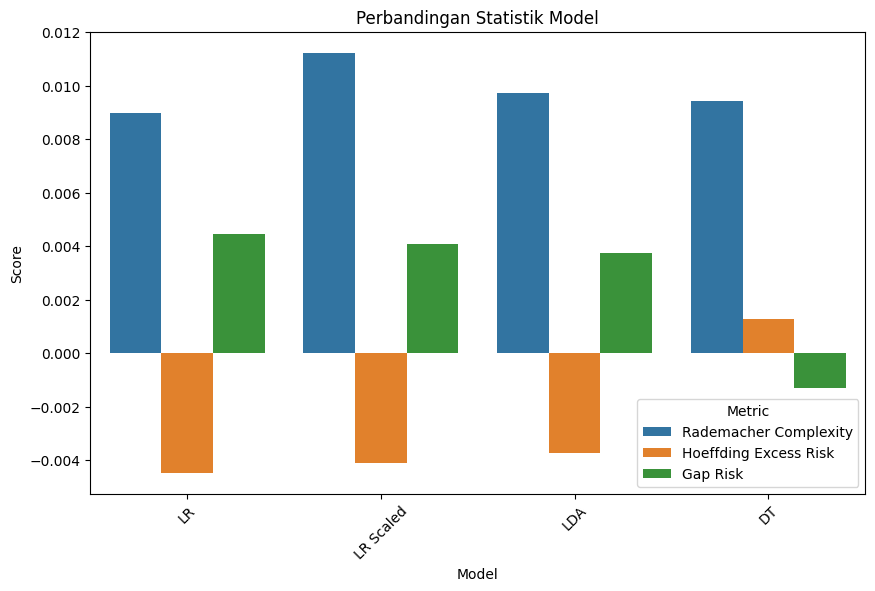

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ubah ke format long
plot_df = stats_df.reset_index().melt(
    id_vars="index",
    value_vars=["Rademacher Complexity", "Hoeffding Excess Risk", "Gap Risk"],
    var_name="Metric",
    value_name="Score"
)

plot_df.rename(columns={"index": "Model"}, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(data=plot_df, x="Model", y="Score", hue="Metric")
plt.title("Perbandingan Statistik Model")
plt.xticks(rotation=45)
plt.show()
